# Synthetic Control - parameter recovery

This notebook shows an example of running Bayesian synthetic control on some synthetic data.

In [1]:
from causal_impact.causal_impact import SyntheticControl

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patheffects as patheffects
import numpy as np
import pandas as pd
from scipy.stats import norm, gamma, dirichlet
from statsmodels.nonparametric.smoothers_lowess import lowess

In [3]:
RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
%config InlineBackend.figure_format = 'retina'

## Generate artifical dataset

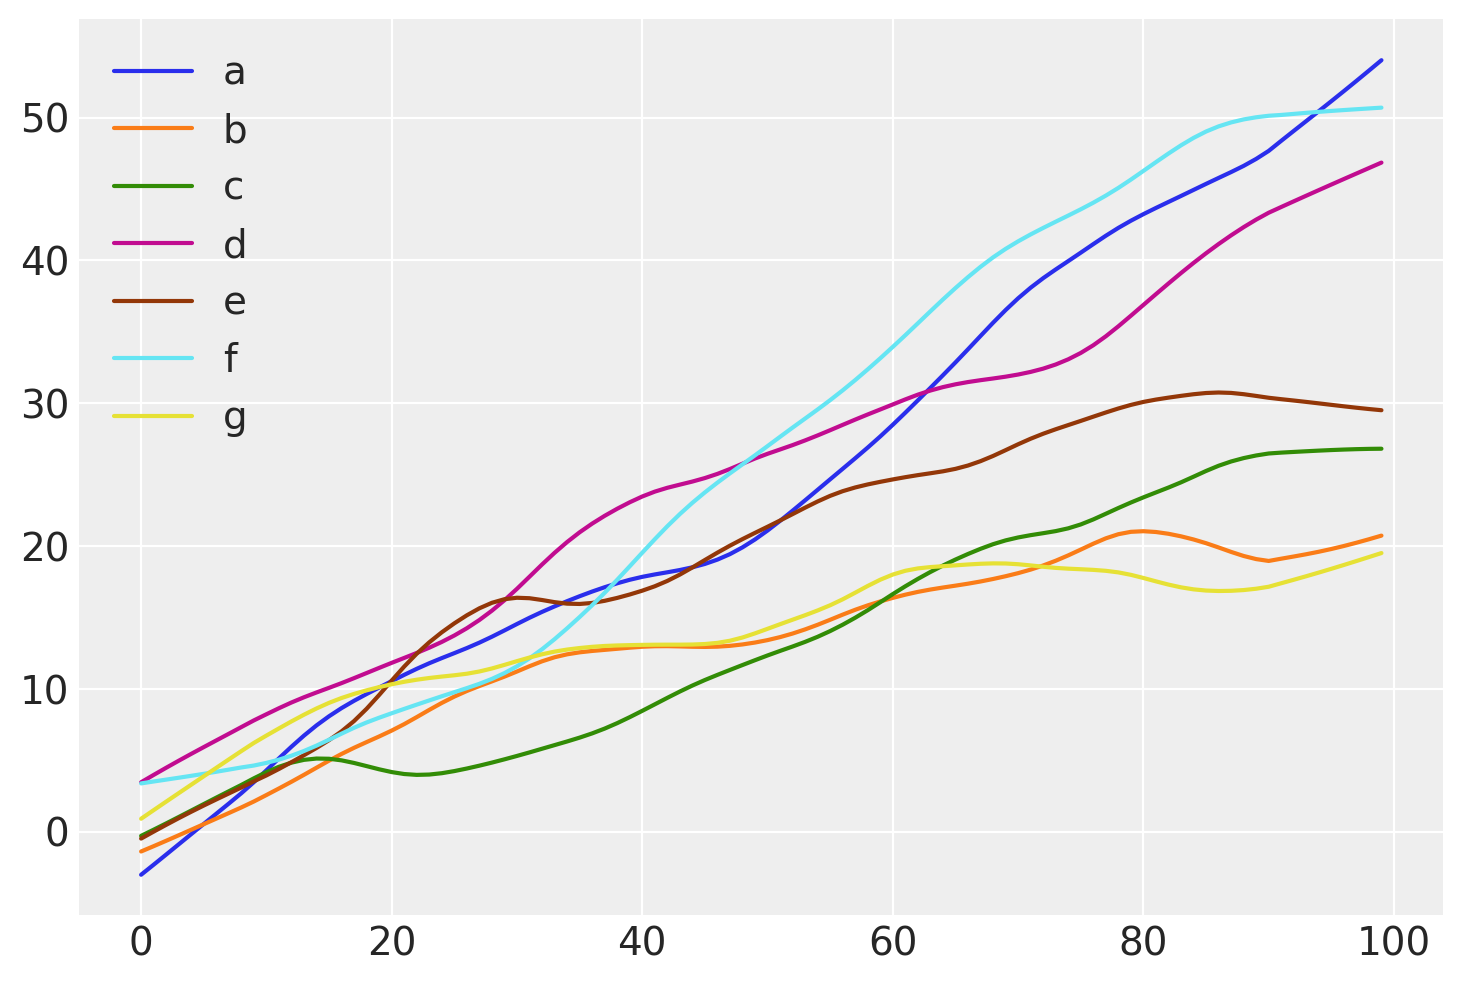

In [4]:
treatment_time = 70
N = 100

def smoothed_gaussian_random_walk(N=100):
    x = np.arange(N)
    y = norm(0.25, 1).rvs(N).cumsum()
    filtered = lowess(y, x, frac=0.2, it=0)
    y = filtered[:,1]
    return (x, y)

df = pd.DataFrame({'a': smoothed_gaussian_random_walk(N=N)[1], 
                   'b': smoothed_gaussian_random_walk(N=N)[1],
                   'c': smoothed_gaussian_random_walk(N=N)[1], 
                   'd': smoothed_gaussian_random_walk(N=N)[1],
                   'e': smoothed_gaussian_random_walk(N=N)[1],
                   'f': smoothed_gaussian_random_walk(N=N)[1],
                   'g': smoothed_gaussian_random_walk(N=N)[1]})

df.plot();

In [5]:
# Generate counterfactual, based on weighted sum of control (untreated) 
# countries. This is the counterfactual with NO treatment.

# true weightings
w_true = dirichlet(np.ones(7)).rvs(1)

# calculate the weighted sum
df['counterfactual'] = np.dot(df.to_numpy(), w_true.T)

# df['counterfactual'] = y

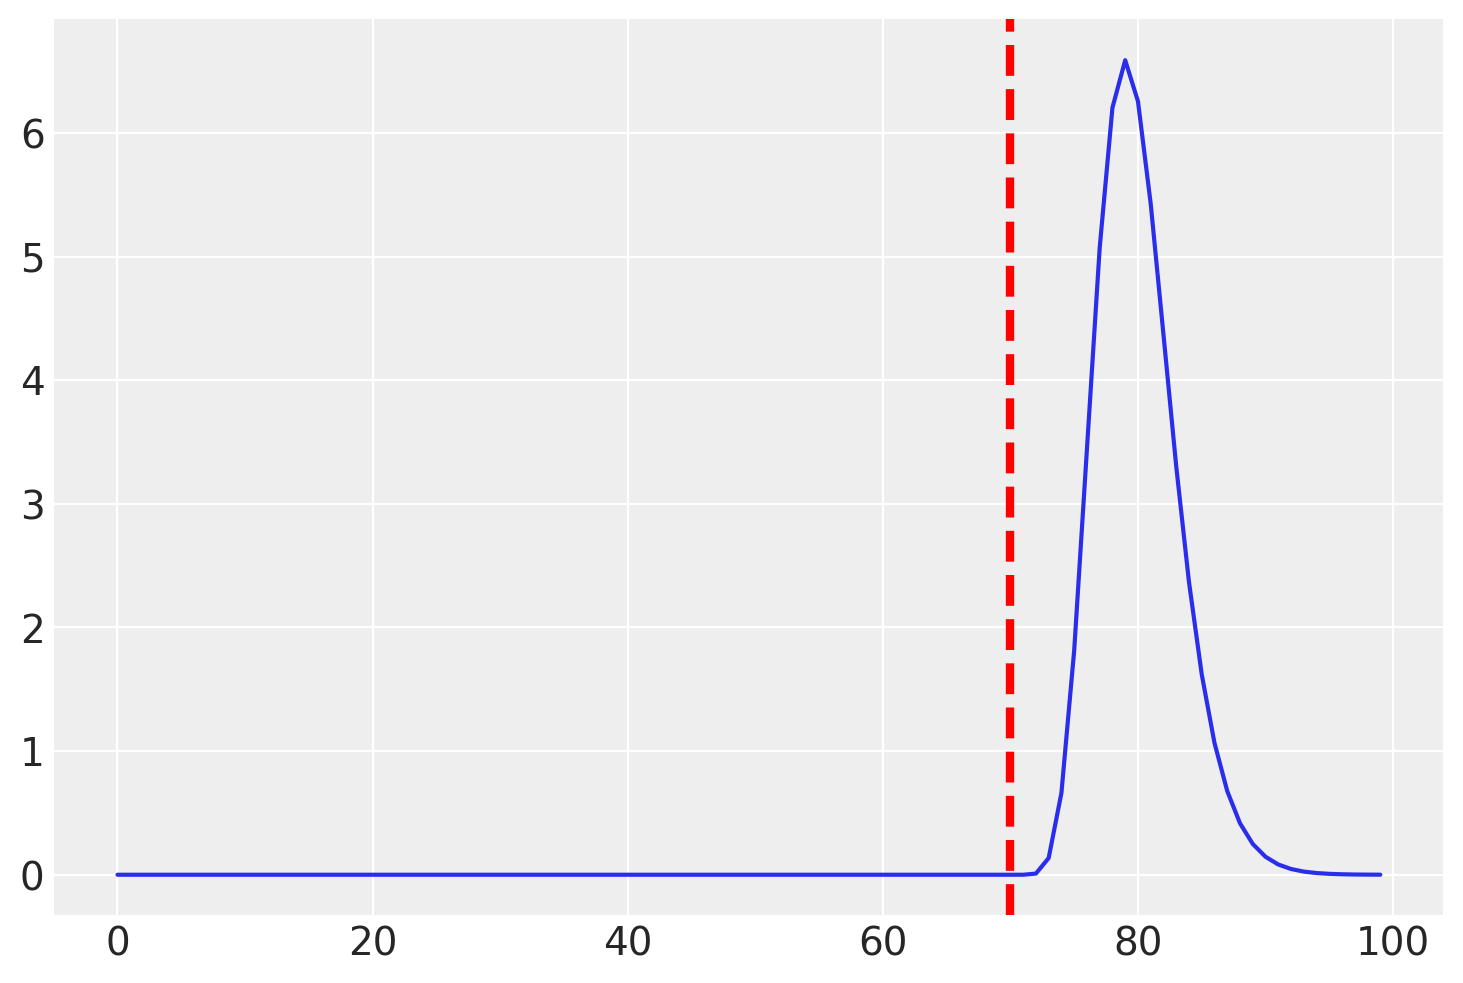

In [6]:
# generate the true causal effect
causal_effect = gamma(10).pdf(np.arange(0,N,1)-treatment_time)
df["causal effect"] = causal_effect * 50
ax = df["causal effect"].plot()
ax.axvline(x=treatment_time, linewidth=3, c='r', ls='--');

In [7]:
# generate the actually observed data, ie the treated with the causal effect applied
df['actual'] = df['counterfactual'] - df["causal effect"]

In [8]:
# apply observation noise to all relevant variables
for var in ['actual', 'a', 'b', 'c', 'd', 'e', 'f', 'g']:
    df[var] += norm(0, 0.25).rvs(N)

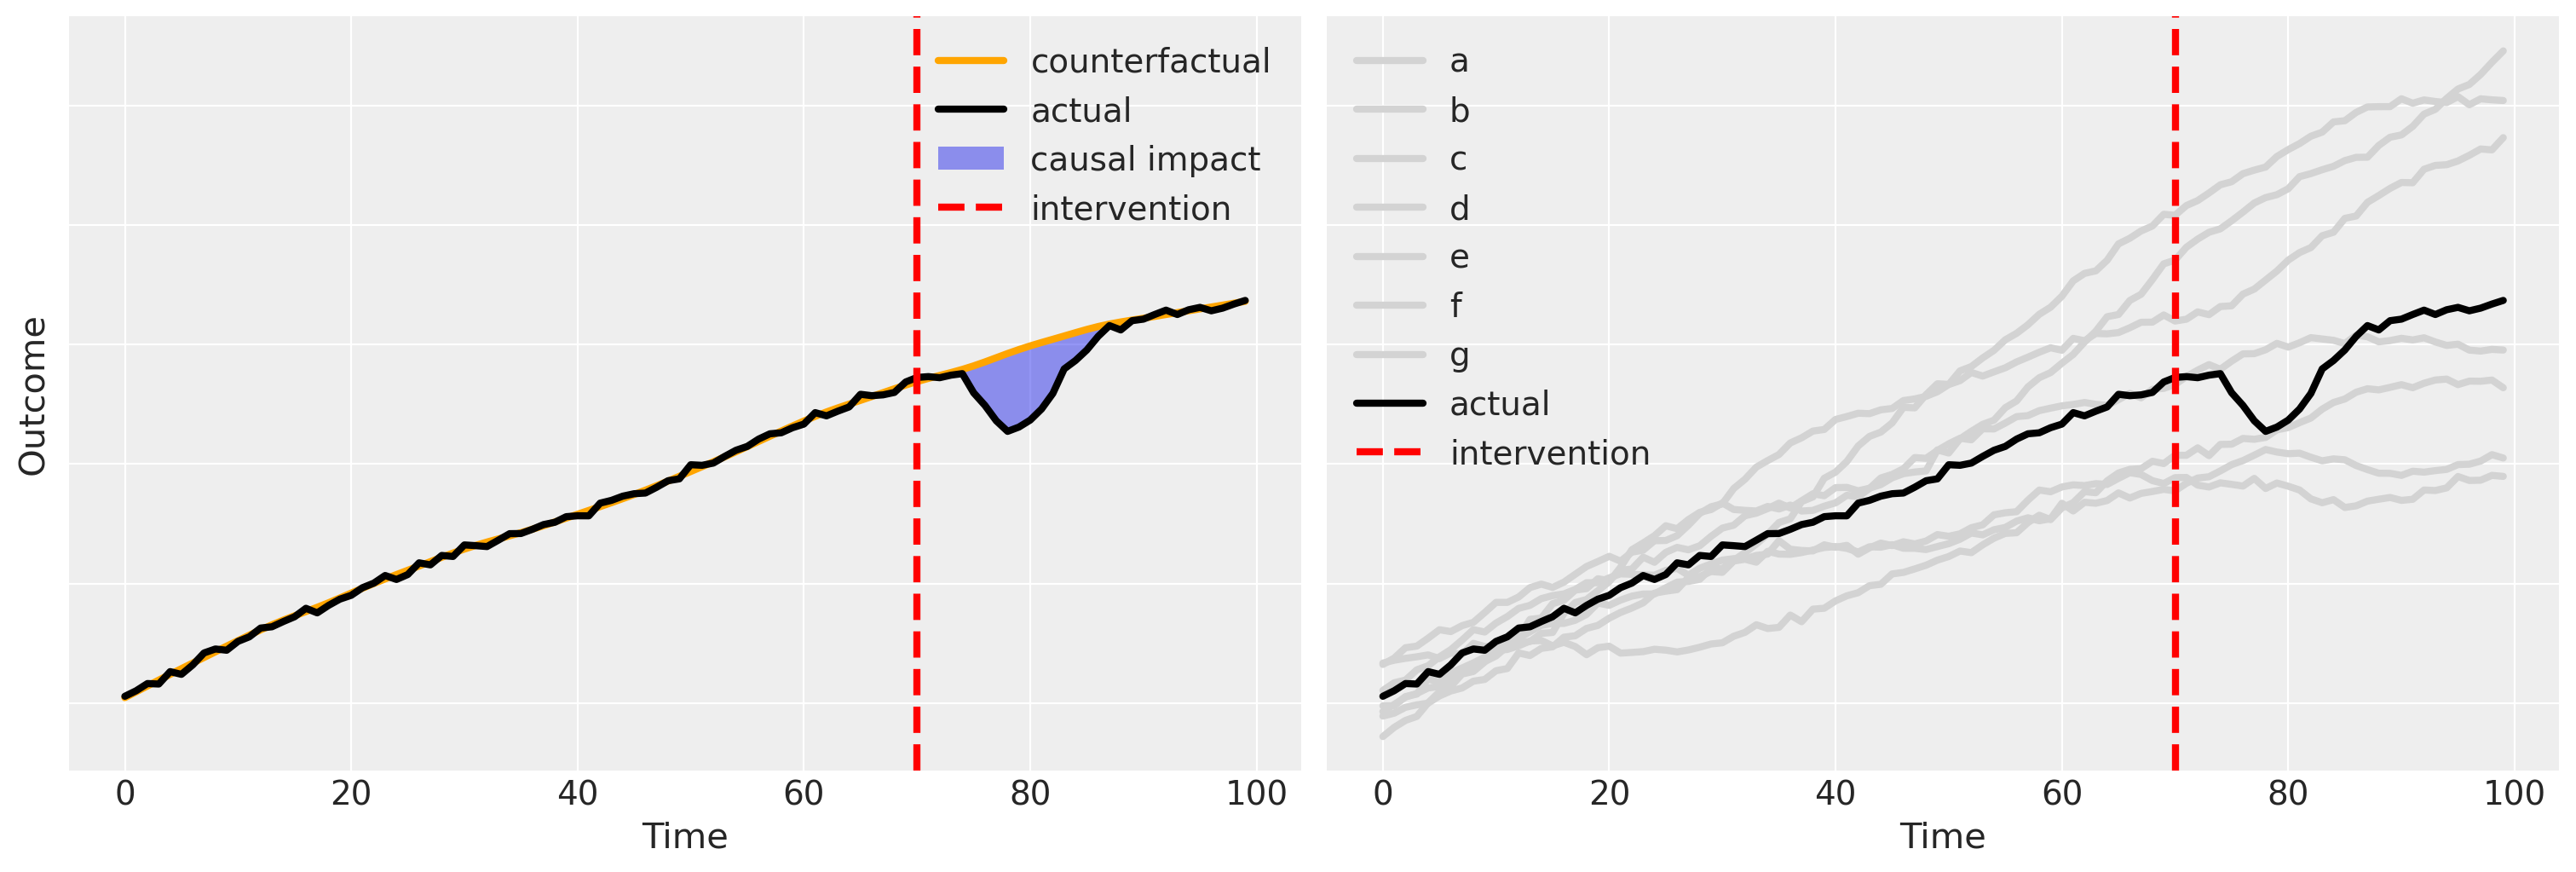

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# WHAT YOU WANT
# df.loc[:, ['a', 'b', 'c', 'd', 'e', 'f', 'g']].plot(c='lightgrey', lw=3)
df.loc[:, ['counterfactual']].plot(c='orange', lw=3, ls="-", ax=ax[0])
df.loc[:, ['actual']].plot(c='k', ax=ax[0], lw=3)
# causal effect shading
ax[0].fill_between(df.index, df['counterfactual'], df['actual'], alpha=0.5, label='causal impact')
# formatting
ax[0].set(xlabel="Time", ylabel="Outcome", yticklabels=[])
ax[0].axvline(x=treatment_time, linewidth=3, c='r', ls='--', label='intervention')
ax[0].legend()

# WHAT YOU HAVE
df.loc[:, ['a', 'b', 'c', 'd', 'e', 'f', 'g']].plot(c='lightgrey', lw=3, ax=ax[1])
# df.loc[:, ['counterfactual']].plot(c='orange', lw=3, ls="-", ax=ax[1])
df.loc[:, ['actual']].plot(c='k', ax=ax[1], lw=3)
# causal effect shading
# ax[1].fill_between(df.index, df['counterfactual'], df['actual'], alpha=0.5, label='causal impact')
# formatting
ax[1].set(xlabel="Time", ylabel="Outcome", yticklabels=[])
ax[1].axvline(x=treatment_time, linewidth=3, c='r', ls='--', label='intervention')
ax[1].legend();

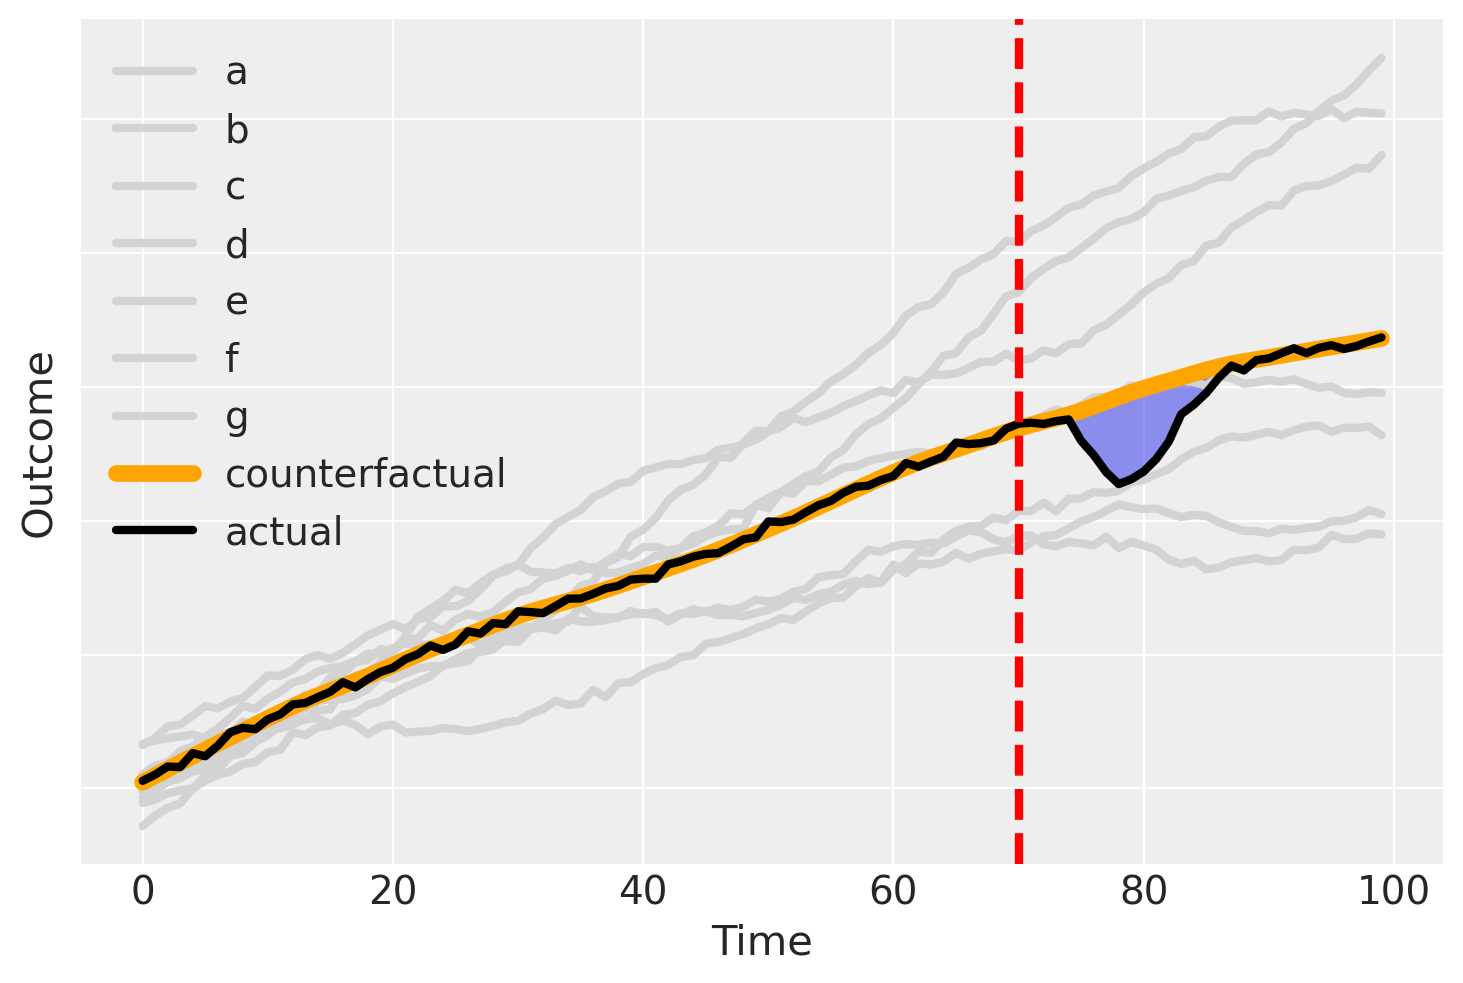

In [10]:
ax = df.loc[:, ['a', 'b', 'c', 'd', 'e', 'f', 'g']].plot(c='lightgrey', lw=3)
df.loc[:, ['counterfactual']].plot(c='orange', ax=ax, lw=6, ls="-")
df.loc[:, ['actual']].plot(c='k', ax=ax, lw=3)

# causal effect shading
ax.fill_between(df.index, df['counterfactual'], df['actual'], alpha=0.5, label='causal impact')

# formatting
ax.set(xlabel="Time", ylabel="Outcome", yticklabels=[])
ax.axvline(x=treatment_time, linewidth=3, c='r', ls='--');

## Run the Bayesian synthetic control model

See if we can infer the causal impact accurately by estimating a synthetic control

In [11]:
result = SyntheticControl (df, 
                          treatment_date=70, 
                          target_var="actual",
                          predictor_vars=['a', 'b', 'c', 'd', 'e', 'f', 'g'])

PRIOR PREDICTIVE CHECK
INFERENCE


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, sigma]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 24 seconds.


POSTERIOR PREDICTIVE CHECK


COUNTERFACTUAL INFERENCE


❗️TODO: add legend for 50/95% CI's❗️

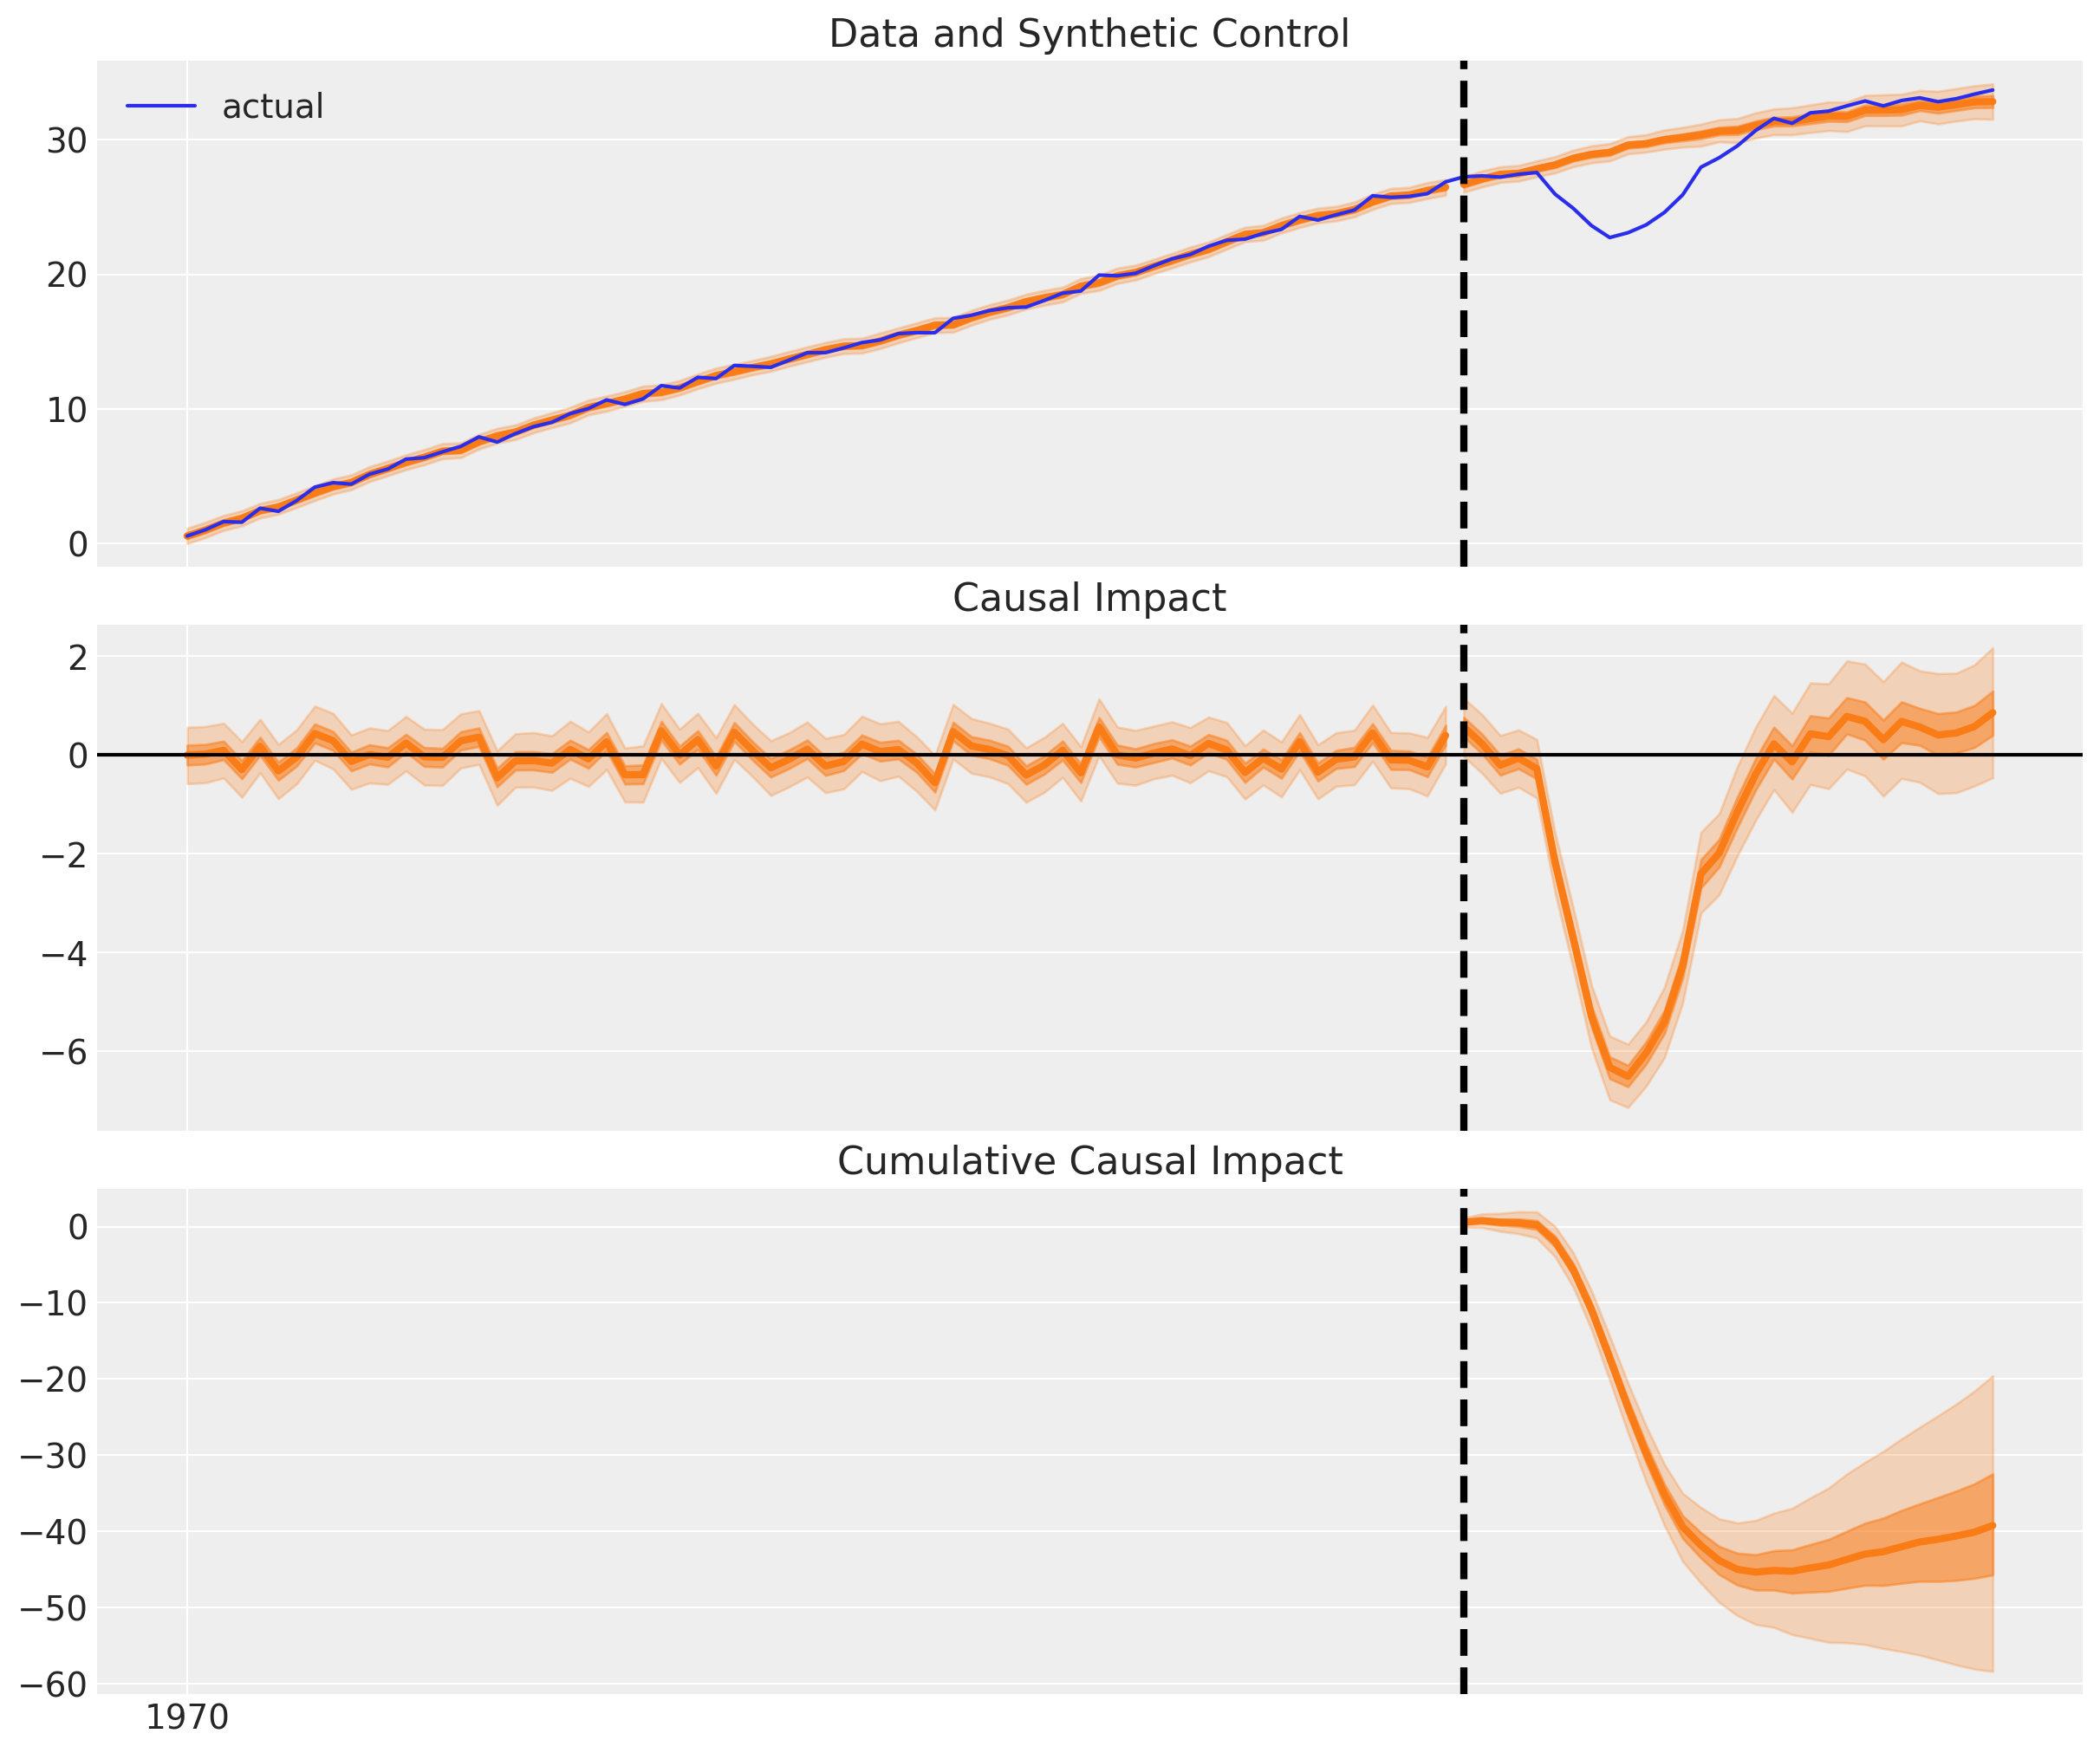

In [12]:
result.plot()

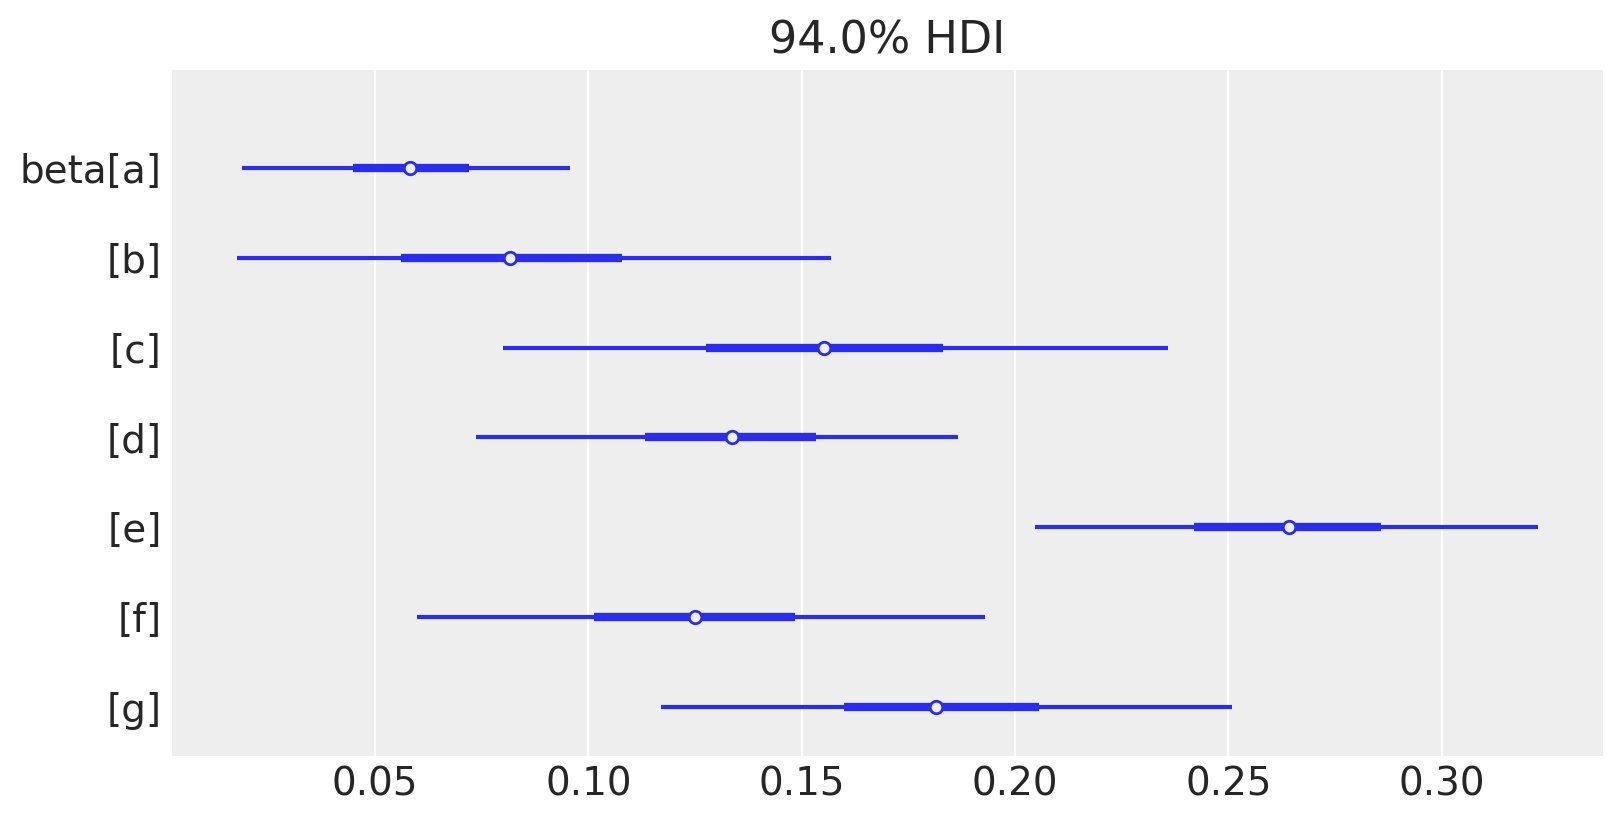

In [13]:
az.plot_forest(result.idata_pre.posterior, var_names="beta", figsize=(8, 4), combined=True);

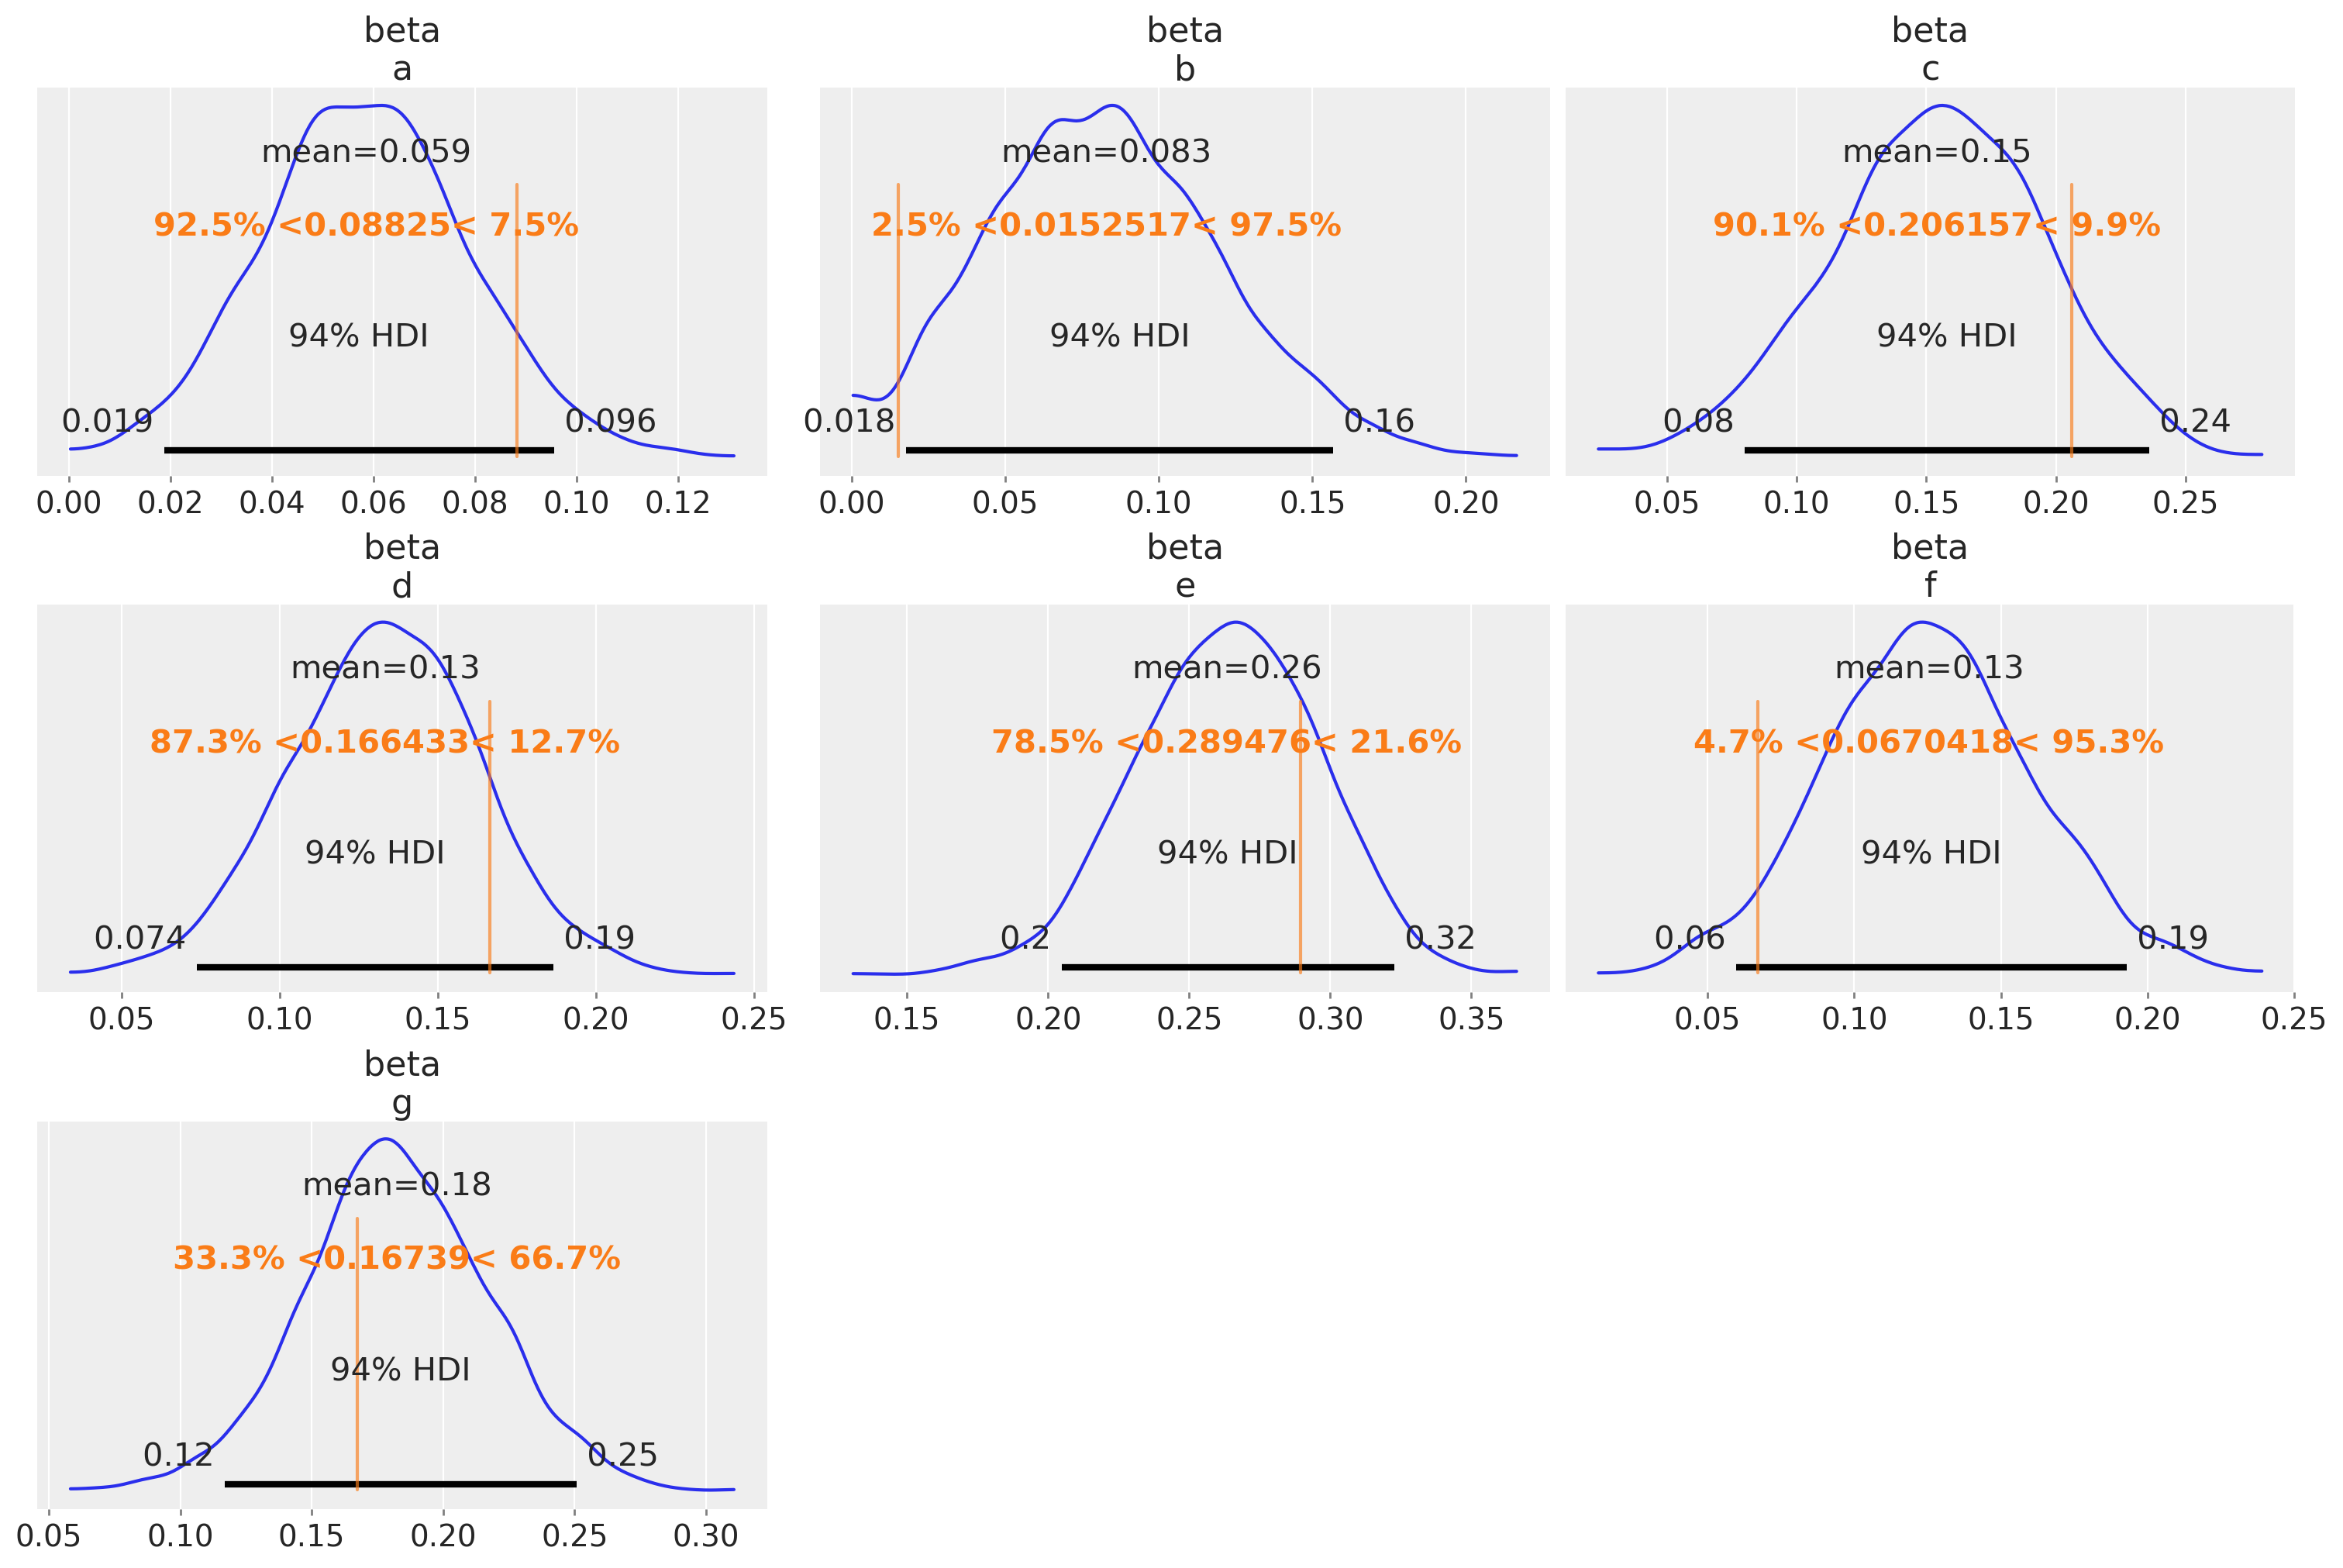

In [14]:
ref_val = {"beta": [{"predictors": "a", "ref_val": w_true[0][0]},
                    {"predictors": "b", "ref_val": w_true[0][1]},
                    {"predictors": "c", "ref_val": w_true[0][2]},
                    {"predictors": "d", "ref_val": w_true[0][3]},
                    {"predictors": "e", "ref_val": w_true[0][4]},
                    {"predictors": "f", "ref_val": w_true[0][5]},
                    {"predictors": "g", "ref_val": w_true[0][6]}]}

az.plot_posterior(result.idata_pre.posterior['beta'], ref_val=ref_val, figsize=(15, 10));